In [1]:
import os,sys
import math

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mlt
import matplotlib.pyplot as plt
from IPython.display import HTML
from matplotlib import animation
import seaborn as sns
from sklearn.model_selection import train_test_split,cross_val_score, KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense
from tensorflow.keras import models
from tensorflow.keras.callbacks import EarlyStopping

sys.path.append("../src")  # adjust path as needed
from read_Parkinsonpredict import ReadData, LoadData
from ml_models import MlModels

### Loading the Gene Expression Data

#### Load the written csv file

In [2]:
path = '/Users/pushpita/Documents/Erdos_bootcamp/our_project/Data/fomatted_data/Updated/with_clinical_data/'

data_gene = pd.read_csv(path + "gene_expression_summary.csv")
# data_encoded = pd.get_dummies(data_gene, columns=['GENDER'])

data_gene["GENDER"] = data_gene["GENDER"].map({"Female": 1, "Male": 0})
data_cleaned = data_gene.dropna(subset=["AGE"])

data_gene_BL = data_cleaned[data_cleaned["EVENT_ID"] == 'BL']
print(f'Printing the shapes for whole Genomic Dataset {data_cleaned.shape},'+'\n'+ f'Shape of the Baseline data {data_gene_BL.shape}')

Printing the shapes for whole Genomic Dataset (3894, 106),
Shape of the Baseline data (1043, 106)


### Baseline NHY Distribution

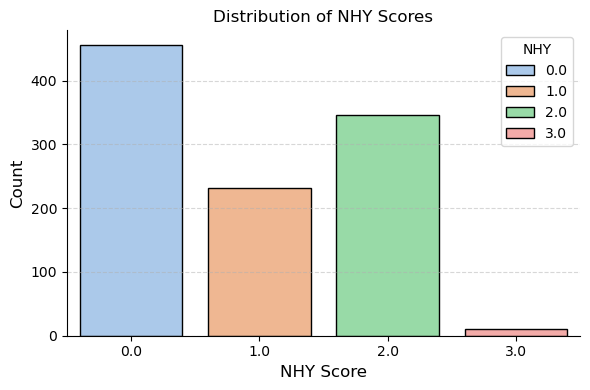

In [3]:
plt.figure(figsize=(6, 4))
sns.countplot(x='NHY', data=data_gene_BL, hue='NHY', palette='pastel', edgecolor='black')
plt.title("Distribution of NHY Scores", fontsize=12)
plt.xlabel("NHY Score", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
sns.despine()
plt.tight_layout()
plt.show()


#### Load the UDPRS Data

In [4]:
HYS_data_path = '/Users/pushpita/Documents/Erdos_bootcamp/our_project/Data/Diagnosis_History_UPDRS_HYS'
HYS_data = pd.read_csv(HYS_data_path+"/MDS-UPDRS_Part_III_03Jun2025.csv")

common_patnos = set(HYS_data['PATNO']) & set(data_gene_BL['PATNO'])

HYS_matched = HYS_data[HYS_data['PATNO'].isin(common_patnos)].copy()
gene_matched = data_gene_BL[data_gene_BL['PATNO'].isin(common_patnos)].copy()

print(f'Printing the shapes for Genomic data {data_gene_BL.shape},'+'\n'+ f'Shape of the HYS Dataset {HYS_data.shape}')
print(f'Printing the shapes for Genomic data (common PATNO) {gene_matched.shape},'+'\n'+ f'Shape of the HYS Dataset (common PATNO) {HYS_matched.shape}')

HYS_matched['LAST_UPDATE'] = pd.to_datetime(HYS_matched['LAST_UPDATE'], errors='coerce')
HYS_sorted = HYS_matched.sort_values(by=['PATNO', 'LAST_UPDATE']).reset_index(drop=True)
HYS_filtered = HYS_sorted[HYS_sorted["NHY"] <= 5]
HYS_last = HYS_filtered.groupby('PATNO').tail(1).reset_index(drop=True)
HYS_first = HYS_filtered.groupby('PATNO').head(1).reset_index(drop=True)
print(f'Printing the shapes for Genomic data (common PATNO) {gene_matched.shape},'+'\n'+ f'Shape of the HYS Dataset (Last HYS) {HYS_last.shape}')

Printing the shapes for Genomic data (1043, 106),
Shape of the HYS Dataset (33258, 63)
Printing the shapes for Genomic data (common PATNO) (1043, 106),
Shape of the HYS Dataset (common PATNO) (17574, 63)
Printing the shapes for Genomic data (common PATNO) (1043, 106),
Shape of the HYS Dataset (Last HYS) (1043, 63)


/var/folders/0v/kl9fb13d2v51vwxc37zr5__00000gn/T/ipykernel_68754/3082452079.py:2: DtypeWarning: Columns (15,19) have mixed types. Specify dtype option on import or set low_memory=False.
  HYS_data = pd.read_csv(HYS_data_path+"/MDS-UPDRS_Part_III_03Jun2025.csv")


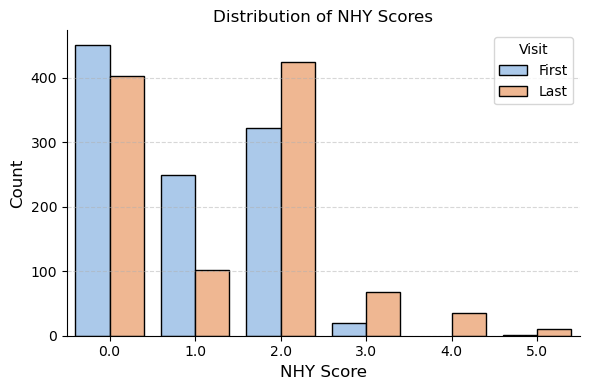

In [5]:
HYS_first['Visit'] = 'First'
HYS_last['Visit'] = 'Last'
HYS_combined = pd.concat([HYS_first, HYS_last])

plt.figure(figsize=(6, 4))
sns.countplot(x='NHY', data=HYS_combined, hue='Visit', palette='pastel', edgecolor='black')
plt.title("Distribution of NHY Scores", fontsize=12)
plt.xlabel("NHY Score", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
sns.despine()
plt.tight_layout()
plt.show()

In [7]:
Y_train_grouped = HYS_last["NHY"].copy()
Y_train_grouped[Y_train_grouped <= 1] = 0
# Y_train_grouped[(Y_train_grouped == 1) | (Y_train_grouped == 2)] = 1
Y_train_grouped[Y_train_grouped > 1] = 2

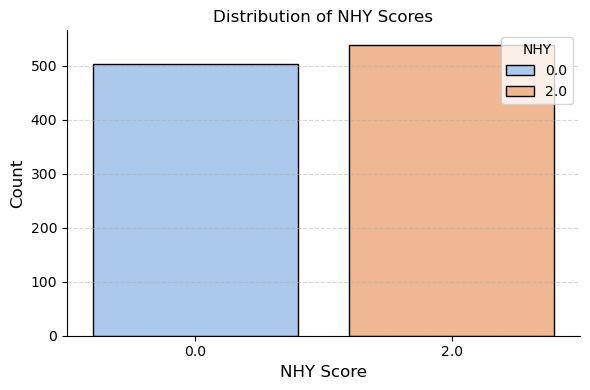

In [8]:
plt.figure(figsize=(6, 4))
sns.countplot(x='NHY', data=Y_train_grouped.to_frame(name='NHY'), hue='NHY', palette='pastel', edgecolor='black')
plt.title("Distribution of NHY Scores", fontsize=12)
plt.xlabel("NHY Score", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
sns.despine()
plt.tight_layout()
plt.show()

In [9]:
X_data = gene_matched.drop(columns=["PATNO", "EVENT_ID", "NHY"])
Y_data = Y_train_grouped
X_, X_test, Y_, Y_test = train_test_split(X_data, Y_data, test_size=0.2, shuffle=True, stratify=Y_data, random_state=42)
X_train, X_cv, Y_train, Y_cv = train_test_split(X_, Y_, test_size=0.10, shuffle=True, stratify=Y_, random_state=42)


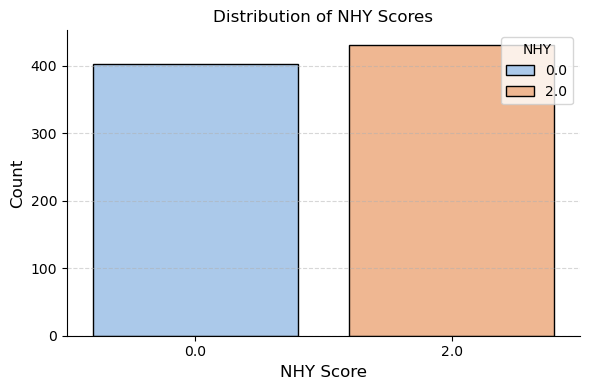

In [10]:
plt.figure(figsize=(6, 4))
sns.countplot(x='NHY', data=Y_.to_frame(name='NHY'), hue='NHY', palette='pastel', edgecolor='black')
plt.title("Distribution of NHY Scores", fontsize=12)
plt.xlabel("NHY Score", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
sns.despine()
plt.tight_layout()
plt.show()

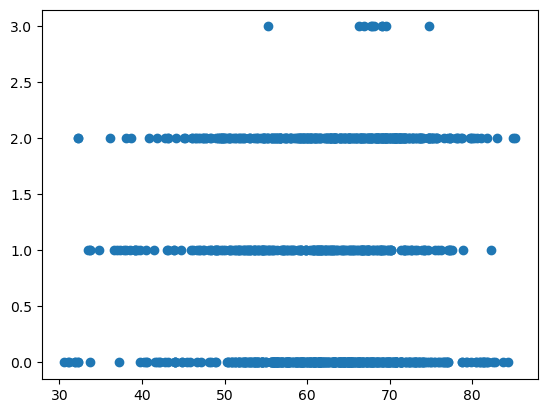

In [11]:
plt.plot(data_gene_BL["AGE"], data_gene_BL["NHY"], 'o')

In [12]:
scaler_cls = StandardScaler()
X_scaled = scaler_cls.fit_transform(X_train)   # learn scaling
X_val_scaled   = scaler_cls.transform(X_cv)               # apply scaling

In [13]:
X_train.head()

,GENDER,AGE,EDUC_YRS,ENSG00000280071,ENSG00000178726,ENSG00000089195,ENSG00000105185,ENSG00000167207,ENSG00000140471,ENSG00000211792,...,ENSG00000124279,ENSG00000064313,ENSG00000106443,ENSG00000261740,ENSG00000204577,ENSG00000213221,ENSG00000166136,ENSG00000165983,ENSG00000254929,ENSG00000135929
1473,0,61.6,15.0,13.61860,5.606890,3.91871,16.2422,14.49150,39.1511,3.32190,...,4.95746,30.8862,24.8562,4.61978,23.6957,6.39113,65.1450,5.81762,1.49401,4.03504
1464,1,66.8,10.0,8.89784,5.288090,3.45922,15.8601,32.20440,43.6657,3.00517,...,5.14871,36.4234,21.0217,6.99837,29.6203,4.66324,62.2279,4.82389,3.44989,5.29175
3636,1,64.1,22.0,15.07590,0.807075,3.87434,16.9625,15.76860,31.1380,4.07503,...,4.02799,33.9473,20.9149,7.42609,21.9501,9.03945,74.2093,5.36425,3.94305,7.50504
450,0,64.8,16.0,11.11030,4.142880,3.88287,12.2408,7.67046,30.8678,3.62498,...,6.02633,30.1803,27.0376,2.10932,22.2377,3.56252,53.9794,6.14162,3.22832,7.18986
1651,1,68.7,13.0,16.43050,6.518760,3.87085,13.1324,18.82760,33.2264,3.56252,...,3.93415,35.0820,18.6222,5.94159,56.9055,1.95076,47.2023,5.74593,3.54740,13.56290


In [14]:
np.any(np.isnan(X_train)), np.any(np.isinf(X_train))
np.any(np.isnan(Y_train)), np.any(np.isinf(Y_train))

(np.False_, np.False_)

In [15]:
print(data_gene_BL.loc[data_gene_BL["AGE"].isna(), "PATNO"])

Series([], Name: PATNO, dtype: int64)


In [16]:
model = models.Sequential([
    Dense(units=6, activation='relu',kernel_regularizer=regularizers.l2(1e-3), name='layer1', input_shape=(X_scaled.shape[1], )),
    Dense(units=5, activation='relu', name='layer2',
          kernel_regularizer=regularizers.l2(1e-3)),
    Dense(3, activation='softmax',
          kernel_regularizer=regularizers.l2(1e-3)) 
])


/Users/pushpita/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
early_stopping = EarlyStopping(
    monitor='val_loss',       # You could also monitor 'val_accuracy'
    patience=10,              # Stop if no improvement for 10 epochs
    restore_best_weights=True # Roll back to best weights
)

In [18]:
history = model.fit(X_scaled, Y_train, epochs=150, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/150


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0819 - loss: 1.2932 - val_accuracy: 0.1467 - val_loss: 1.2273
Epoch 2/150
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2082 - loss: 1.1886 - val_accuracy: 0.2667 - val_loss: 1.1645
Epoch 3/150
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3306 - loss: 1.1458 - val_accuracy: 0.3267 - val_loss: 1.1244
Epoch 4/150
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3799 - loss: 1.1113 - val_accuracy: 0.4000 - val_loss: 1.1004
Epoch 5/150
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4696 - loss: 1.0900 - val_accuracy: 0.4333 - val_loss: 1.0831
Epoch 6/150
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4757 - loss: 1.0741 - val_accuracy: 0.4467 - val_loss: 1.0694
Epoch 7/150
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5321 - loss: 1.0611 - val_accuracy: 0.4600 - val_loss: 1.0577
Epoch 8/150
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5490 - loss: 1.0486 - val_accuracy: 0.4667 - val_loss: 1.0

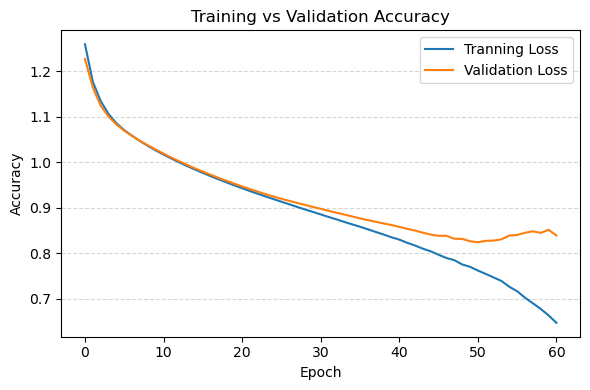

In [19]:
plt.figure(figsize=(6, 4))
plt.plot(history.history["loss"], label='Tranning Loss')
plt.plot(history.history["val_loss"], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [20]:
val_loss, val_accuracy = model.evaluate(X_val_scaled, Y_cv)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5707 - loss: 0.8182 


In [21]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
clf.fit(X_train, Y_train)
print("Validation accuracy:", clf.score(X_cv, Y_cv))

Validation accuracy: 0.5833333333333334


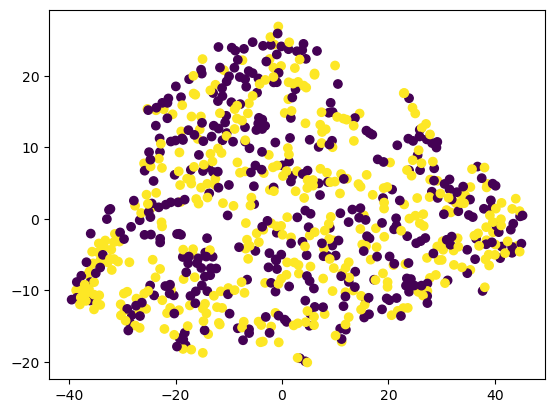

In [22]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
X_embedded = tsne.fit_transform(X_train)
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=Y_train)

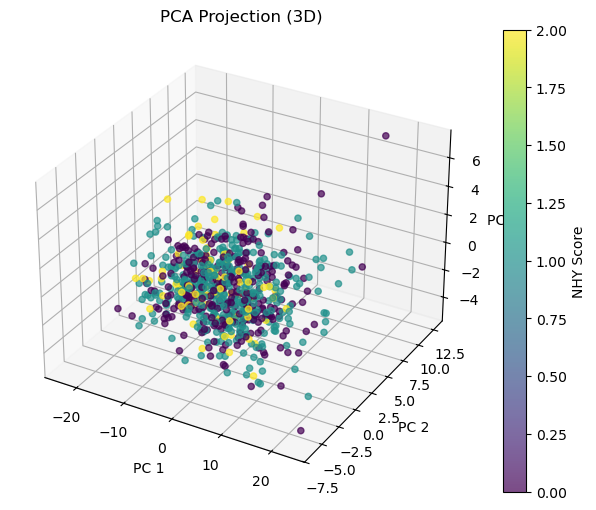

In [21]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=Y_train, cmap='viridis', alpha=0.7)
fig.colorbar(p, label='NHY Score')
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
plt.title('PCA Projection (3D)')
plt.show()

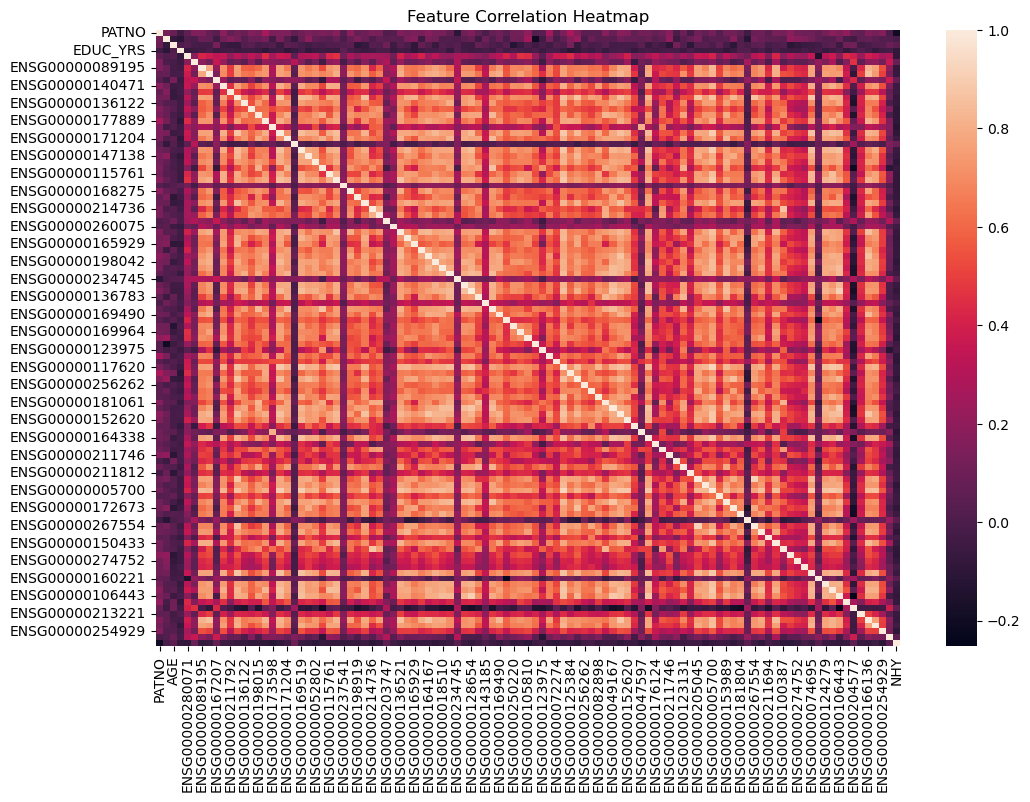

In [22]:
plt.figure(figsize=(12, 8))
sns.heatmap(data_cleaned.corr(numeric_only=True), annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()